In [1]:
# Core PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# Torchvision for MNIST
import torchvision
import torchvision.transforms as transforms

# Visualization and array operations
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [2]:
# Define transforms (normalize to [0,1] range)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load MNIST
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 429kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.04MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.9MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])


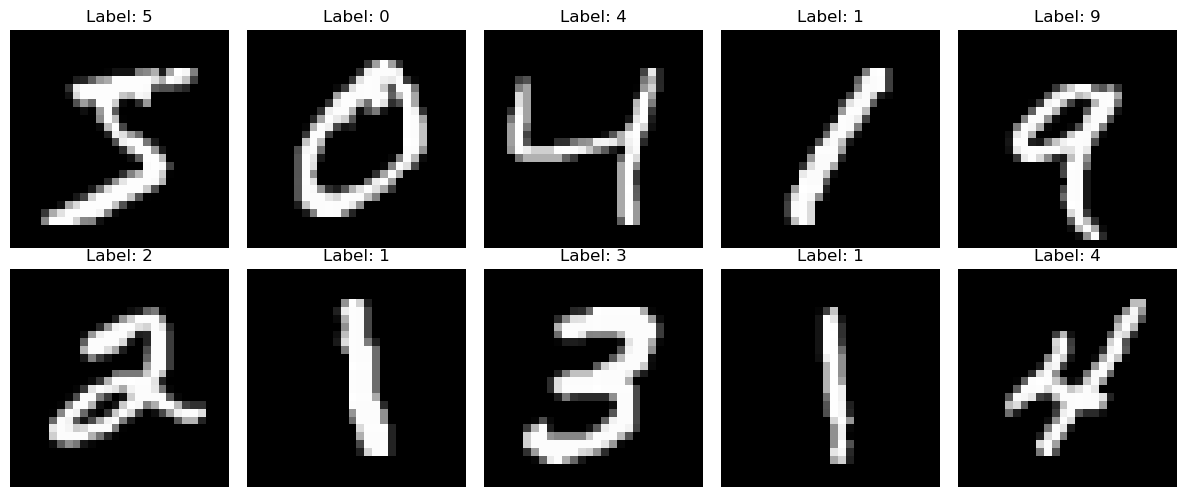


Dataset structure:
Image tensor shape: torch.Size([1, 28, 28])
Label type: <class 'int'>
Pixel value range: [-0.42, 2.82]


In [3]:
# Get a few samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    # Denormalize and convert to numpy
    img = img.squeeze().numpy() * 0.3081 + 0.1307
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Check structure
print(f"\nDataset structure:")
print(f"Image tensor shape: {train_dataset[0][0].shape}")
print(f"Label type: {type(train_dataset[0][1])}")
print(f"Pixel value range: [{train_dataset[0][0].min():.2f}, {train_dataset[0][0].max():.2f}]")

In [5]:
class SimpleCNN_BiasFree(nn.Module):
    def __init__(self):
        super(SimpleCNN_BiasFree, self).__init__()
        # Convolutional layers WITHOUT bias
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False)

        # Fully connected layers WITHOUT bias
        self.fc1 = nn.Linear(32 * 7 * 7, 128, bias=False)
        self.fc2 = nn.Linear(128, 10, bias=False)

        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
model = SimpleCNN_BiasFree().to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

SimpleCNN_BiasFree(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=False)
  (fc2): Linear(in_features=128, out_features=10, bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Total parameters: 206,736


In [6]:
def train_epoch(model, train_loader, optimizer, criterion, device, noise_std=0.0):
    """Train for one epoch with optional Gaussian noise injection"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Add Gaussian noise to inputs if specified
        if noise_std > 0:
            noise = torch.randn_like(images) * noise_std
            images = images + noise

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def test(model, test_loader, criterion, device):
    """Evaluate on test set"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

# Initialize model, loss, optimizer
model = SimpleCNN_BiasFree().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model initialized. Ready to train.")

Model initialized. Ready to train.


Training for 1 epochs with noise_std=0.85
------------------------------------------------------------
Epoch  1/1 | Train Loss: 0.0245 | Train Acc: 99.21% | Test Loss: 0.0357 | Test Acc: 99.21%
------------------------------------------------------------
Final Test Accuracy: 99.21%


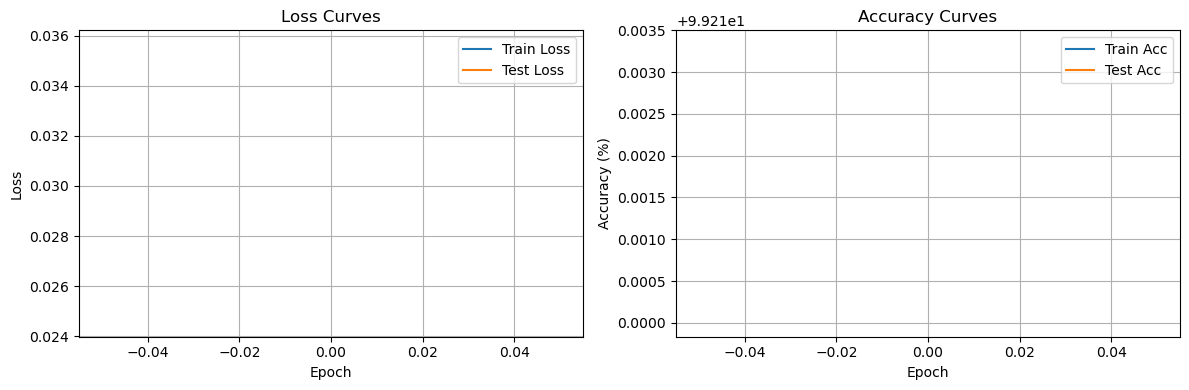

In [28]:
# Training parameters
num_epochs = 1
noise_std = 0.85  # Set to 0.1 or 0.2 to add noise during training

# Training history
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print(f"Training for {num_epochs} epochs with noise_std={noise_std}")
print("-" * 60)

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, criterion, device, noise_std=noise_std
    )

    # Test
    test_loss, test_acc = test(model, test_loader, criterion, device)

    # Store history
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # Print progress
    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

print("-" * 60)
print(f"Final Test Accuracy: {test_accs[-1]:.2f}%")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curves')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Acc')
ax2.plot(test_accs, label='Test Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Computing Jacobians and contributions for 5 test images...


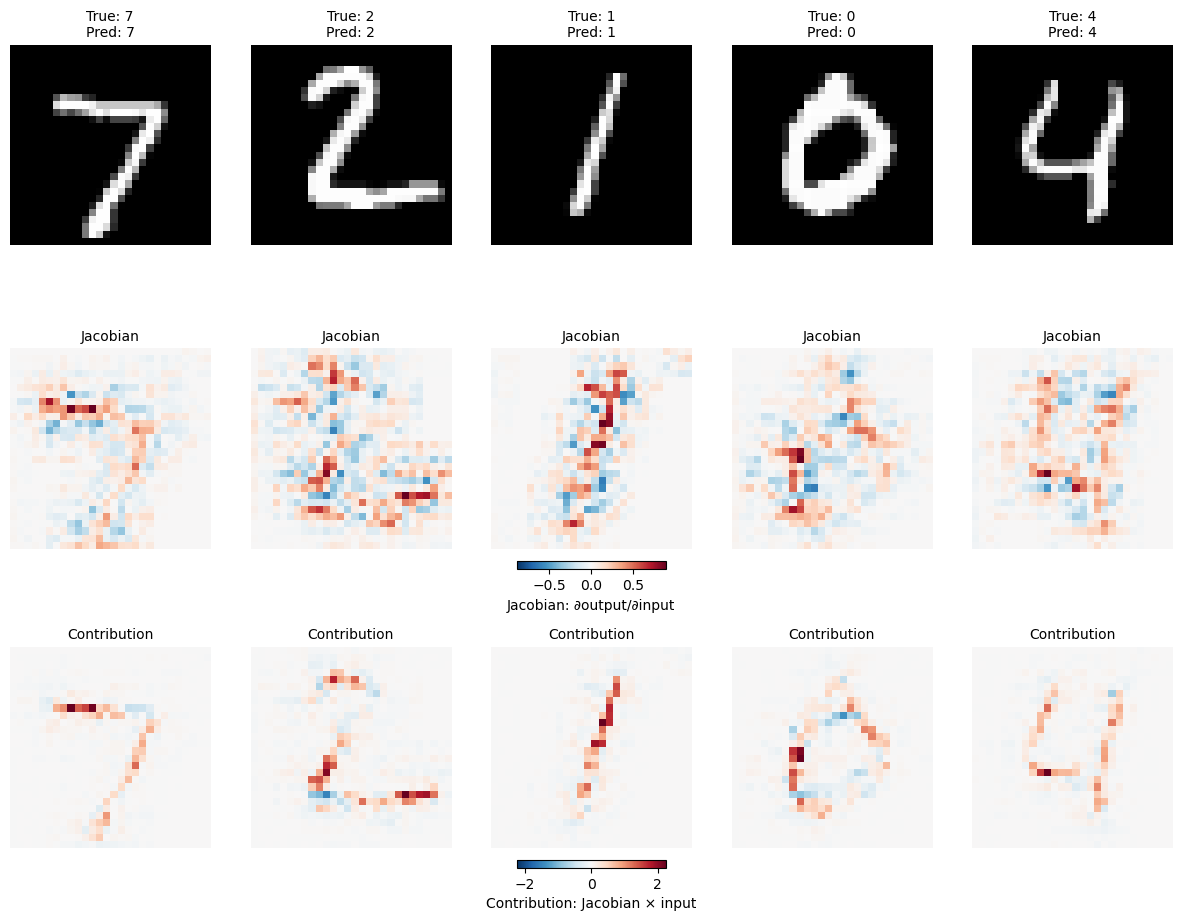


Interpretation:
- Row 1: Original digit images
- Row 2: Jacobian (∂output/∂input) - sensitivity of output to each pixel
- Row 3: Contribution (Jacobian × input) - actual pixel contribution to output

For bias-free networks: sum of all contributions ≈ output logit
Blue = positive contribution, Red = negative contribution


In [38]:
def compute_jacobian_for_predicted_class(model, image):
    """
    Compute Jacobian of predicted class output w.r.t. input image

    Returns:
        jacobian: shape (28, 28) - gradient of predicted class logit w.r.t. each pixel
        predicted_class: the predicted digit
        logits: the output logits
    """
    image.requires_grad = True

    # Forward pass
    output = model(image.unsqueeze(0))  # Add batch dimension
    predicted_class = output.argmax(dim=1).item()

    # Backward pass for predicted class
    model.zero_grad()
    output[0, predicted_class].backward()

    jacobian = image.grad.squeeze().cpu().numpy()  # Shape: (1, 28, 28) -> (28, 28)

    return jacobian, predicted_class, output.detach().cpu().numpy()

def visualize_jacobians_with_contribution(model, test_dataset, n=5, device='cpu'):
    """
    Visualize original images, Jacobians, and actual pixel contributions

    For bias-free networks: output = Jacobian @ input
    So: pixel_contribution = jacobian * input (elementwise)
    """
    model.eval()

    fig, axes = plt.subplots(3, n, figsize=(3*n, 11))

    for i in range(n):
        # Get test sample
        image, true_label = test_dataset[i]
        image = image.to(device)

        # Compute Jacobian
        with torch.enable_grad():
            jacobian, pred_class, logits = compute_jacobian_for_predicted_class(model, image)

        # Get normalized input image
        img_normalized = image.detach().squeeze().cpu().numpy()  # Still normalized

        # Compute actual contribution: jacobian * input (elementwise)
        contribution = jacobian * img_normalized

        # Denormalize image for display
        img_display = img_normalized * 0.3081 + 0.1307

        # Row 1: original images
        axes[0, i].imshow(img_display, cmap='gray')
        axes[0, i].set_title(f'True: {true_label}\nPred: {pred_class}', fontsize=10)
        axes[0, i].axis('off')

        # Row 2: Jacobian (sensitivity)
        vmax_jac = np.abs(jacobian).max()
        axes[1, i].imshow(jacobian, cmap='RdBu_r', vmin=-vmax_jac, vmax=vmax_jac)
        axes[1, i].set_title(f'Jacobian', fontsize=10)
        axes[1, i].axis('off')

        # Row 3: Contribution (jacobian * input)
        vmax_contrib = np.abs(contribution).max()
        im = axes[2, i].imshow(contribution, cmap='RdBu_r', vmin=-vmax_contrib, vmax=vmax_contrib)
        axes[2, i].set_title(f'Contribution', fontsize=10)
        axes[2, i].axis('off')

    # Add colorbars
    fig.colorbar(axes[1, 0].images[0], ax=axes[1, :], orientation='horizontal',
                 pad=0.05, fraction=0.03, label='Jacobian: ∂output/∂input')
    fig.colorbar(im, ax=axes[2, :], orientation='horizontal',
                 pad=0.05, fraction=0.03, label='Contribution: Jacobian × input')

    plt.show()

# Run visualization
n_samples = 5
print(f"Computing Jacobians and contributions for {n_samples} test images...")
visualize_jacobians_with_contribution(model, test_dataset, n=n_samples, device=device)
print("\nInterpretation:")
print("- Row 1: Original digit images")
print("- Row 2: Jacobian (∂output/∂input) - sensitivity of output to each pixel")
print("- Row 3: Contribution (Jacobian × input) - actual pixel contribution to output")
print("\nFor bias-free networks: sum of all contributions ≈ output logit")
print("Blue = positive contribution, Red = negative contribution")

Computing Jacobians for 2500 samples...
  Processed 1000/2500
  Processed 2000/2500
Jacobian matrix shape: (2500, 784)

PCA explained variance: [0.03557627 0.02847166]
Total variance explained: 0.064


/home/ubuntu/miniconda3/envs/gpmap/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


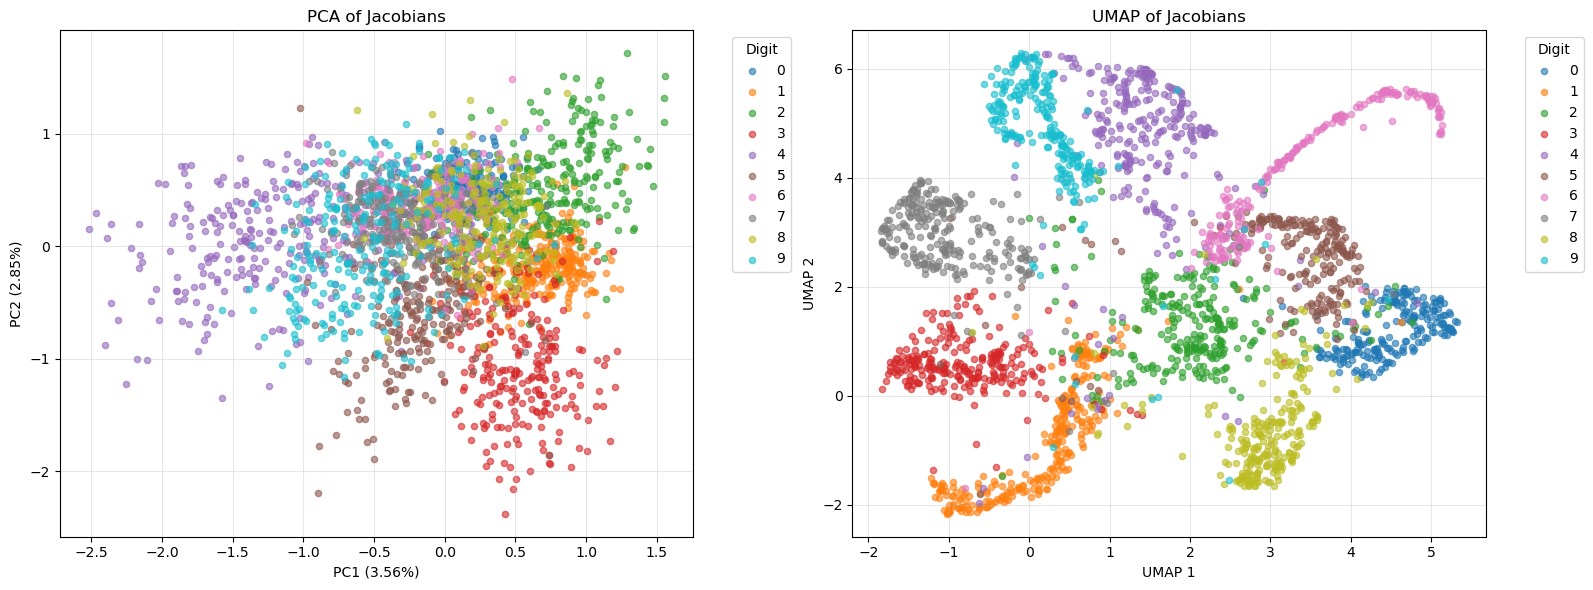

In [30]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Note: you'll need to install umap-learn: pip install umap-learn
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("UMAP not available. Install with: pip install umap-learn")

def harvest_jacobians(model, test_dataset, n_samples=500, device='cpu'):
    """
    Compute Jacobians for n_samples test images

    Returns:
        jacobians: (n_samples, 784) flattened Jacobian matrices
        labels: (n_samples,) true labels
        predictions: (n_samples,) predicted labels
    """
    model.eval()

    jacobians = []
    labels = []
    predictions = []

    print(f"Computing Jacobians for {n_samples} samples...")
    for i in range(n_samples):
        image, label = test_dataset[i]
        image = image.to(device)

        with torch.enable_grad():
            jacobian, pred_class, _ = compute_jacobian_for_predicted_class(model, image)

        jacobians.append(jacobian.flatten())  # 28x28 -> 784
        labels.append(label)
        predictions.append(pred_class)

        if (i + 1) % 1000 == 0:
            print(f"  Processed {i+1}/{n_samples}")

    jacobians = np.array(jacobians)  # Shape: (n_samples, 784)
    labels = np.array(labels)
    predictions = np.array(predictions)

    print(f"Jacobian matrix shape: {jacobians.shape}")
    return jacobians, labels, predictions

def visualize_jacobian_embedding(jacobians, labels, method='pca'):
    """
    Visualize Jacobians in 2D using PCA or UMAP, colored by digit

    Args:
        jacobians: (n_samples, 784) Jacobian vectors
        labels: (n_samples,) digit labels
        method: 'pca', 'umap', or 'both'
    """
    n_components = 2

    if method in ['pca', 'both']:
        # Apply PCA
        pca = PCA(n_components=n_components)
        embedding_pca = pca.fit_transform(jacobians)

        print(f"\nPCA explained variance: {pca.explained_variance_ratio_}")
        print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

    if method in ['umap', 'both']:
        if not HAS_UMAP:
            print("UMAP not available, skipping...")
        else:
            # Apply UMAP
            reducer = umap.UMAP(n_components=n_components, random_state=42)
            embedding_umap = reducer.fit_transform(jacobians)

    # Plotting
    if method == 'both':
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(8, 6))
        axes = [axes]

    # Color map for digits
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    # Plot PCA
    if method in ['pca', 'both']:
        ax = axes[0] if method == 'both' else axes[0]
        for digit in range(10):
            mask = labels == digit
            ax.scatter(embedding_pca[mask, 0], embedding_pca[mask, 1],
                      c=[colors[digit]], label=str(digit), alpha=0.6, s=20)
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
        ax.set_title('PCA of Jacobians')
        ax.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)

    # Plot UMAP
    if method in ['umap', 'both'] and HAS_UMAP:
        ax = axes[1] if method == 'both' else axes[0]
        for digit in range(10):
            mask = labels == digit
            ax.scatter(embedding_umap[mask, 0], embedding_umap[mask, 1],
                      c=[colors[digit]], label=str(digit), alpha=0.6, s=20)
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        ax.set_title('UMAP of Jacobians')
        ax.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run the analysis
n_samples = 2500  # Use more for better UMAP
jacobians, labels, predictions = harvest_jacobians(model, test_dataset, n_samples=n_samples, device=device)

# Visualize with both PCA and UMAP
visualize_jacobian_embedding(jacobians, labels, method='both')